# Notebook 04 – Neural Network Model

In [42]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasClassifier


## Load data

In [43]:
data_path = r"C:/Users/USER/PycharmProjects/ML/data/Telco-Customer-Churn.csv"
df = pd.read_csv(data_path)

## Data Cleaning

In [44]:
df = df.drop(columns=["customerID"], errors="ignore")
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})
df = df.dropna(subset=["Churn"])

X = df.drop("Churn", axis=1)
y = df["Churn"]

## Load Preprocessor

In [45]:
preprocessor = joblib.load("results/preprocessor.pkl")
print("Preprocessor loaded successfully.")



Preprocessor loaded successfully.


## Split Features

In [46]:
X_pre = preprocessor.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_pre, y, test_size=0.2, random_state=42, stratify=y
)

## Build Neural Network Function

In [47]:
def build_nn(hidden_units=32, dropout_rate=0.3):
    model = keras.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(hidden_units, activation="relu"),
        layers.Dropout(dropout_rate),
        layers.Dense(hidden_units // 2, activation="relu"),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

## Train Baseline Model

In [48]:
baseline_model = build_nn()
history_baseline = baseline_model.fit(
    X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0
)

y_pred_baseline = (baseline_model.predict(X_test) > 0.5).astype(int)
print("Baseline Accuracy (Before Tuning):", accuracy_score(y_test, y_pred_baseline))

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Baseline Accuracy (Before Tuning): 0.7963094393186657


## Hyperparameter Tuning

In [56]:
keras_clf = KerasClassifier(
    model=build_nn,
    hidden_units=32,
    dropout_rate=0.3,
    epochs=20,
    batch_size=32,
    verbose=0,
    random_state=42
)

In [57]:
param_dist = {
    "model__hidden_units": [32, 64, 128, 256],
    "model__dropout_rate": [0.2, 0.3, 0.4, 0.5],
    "batch_size": [16, 32, 64],
    "epochs": [20, 30, 40, 50]
}



In [58]:
rs_nn = RandomizedSearchCV(
    estimator=keras_clf,
    param_distributions=param_dist,
    n_iter=5,
    scoring="accuracy",
    cv=5,
    verbose=1,
    random_state=42
)

rs_nn.fit(X_train, y_train)

print("Best parameters:", rs_nn.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'model__hidden_units': 256, 'model__dropout_rate': 0.5, 'epochs': 20, 'batch_size': 64}


## Accuracy AFTER Tuning

In [59]:
y_pred_tuned = (rs_nn.predict(X_test) > 0.5).astype(int)

print("Tuned Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tuned))

Tuned Accuracy: 0.7970191625266146

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.66      0.49      0.56       374

    accuracy                           0.80      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



## Confusion matrix

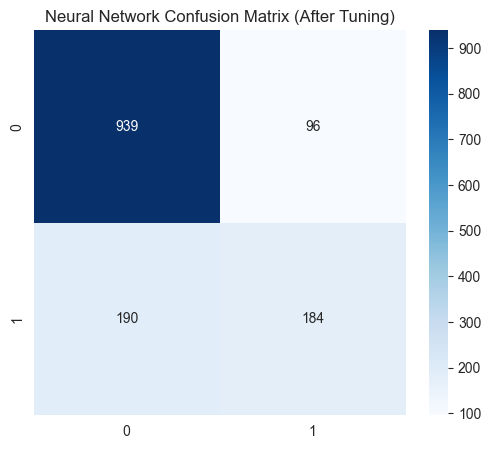

In [60]:
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_tuned), annot=True, fmt='d', cmap='Blues')
plt.title("Neural Network Confusion Matrix (After Tuning)")
plt.show()

## ROC curve

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


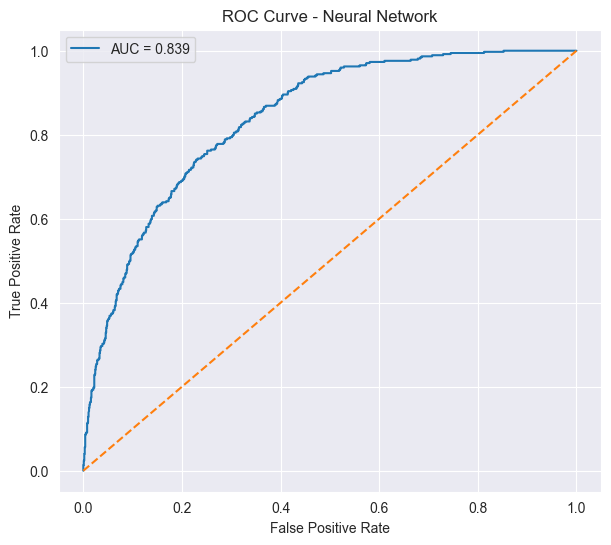

In [61]:
best_model = rs_nn.best_estimator_.model_
y_pred_proba_nn = best_model.predict(X_test).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_nn)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve - Neural Network")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

## Training curves

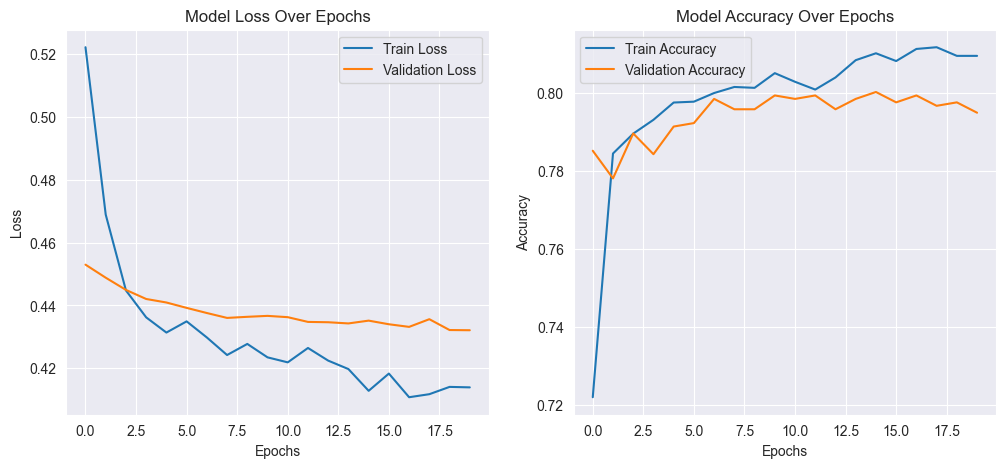

In [63]:
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


## Save Best Tuned Model

In [64]:
best_model.save("results/nn_model.h5")
print("Neural Network model saved as nn_model.h5")

Neural Network model saved as nn_model.h5
